In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/umkc-2023-fall-cs-5590-math-5555-optimization/train.pt
/kaggle/input/umkc-2023-fall-cs-5590-math-5555-optimization/test.pt


In [2]:
#Import library - Mostly copy paste
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!ls ../input

umkc-2023-fall-cs-5590-math-5555-optimization


In [4]:
train = torch.load('/kaggle/input/umkc-2023-fall-cs-5590-math-5555-optimization/train.pt')
test = torch.load('/kaggle/input/umkc-2023-fall-cs-5590-math-5555-optimization/test.pt')

In [5]:
train_data, train_targets = train['data'], train['label']
test_data = test['data']

In [6]:
#Verifying the shapes
print(f'The shapes of train data, train targets, test data are \n {train_data.size()}, {train_targets.size()}, {test_data.size()}')

The shapes of train data, train targets, test data are 
 torch.Size([40000, 28, 28]), torch.Size([40000]), torch.Size([30000, 28, 28])


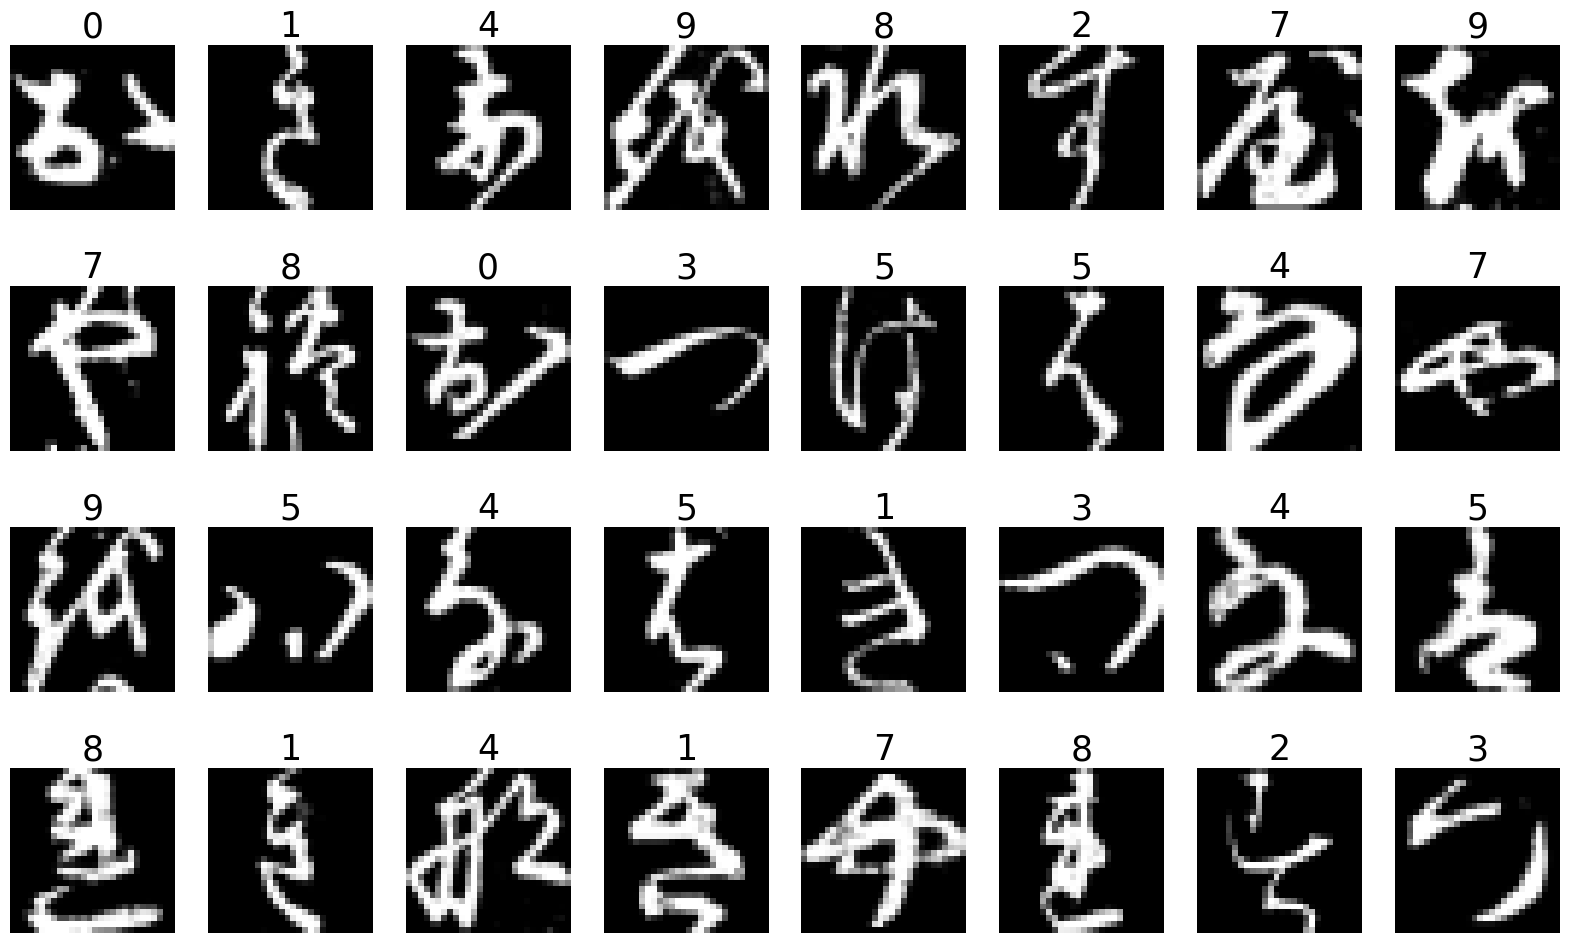

In [7]:
fig, axes = plt.subplots(4, 8, figsize = (20, 12))
axes = axes.reshape(-1)
np.random.seed(1)
idx = np.random.choice(len(train_data), size = 32)

for i, ix in enumerate(idx):
    axes[i].axis('off') # hide the axes ticks
    axes[i].imshow(train_data[ix], cmap = 'gray')
    axes[i].set_title(str(int(train_targets[ix])), color = 'black', fontsize = 25)
plt.show()

In [8]:
#Try to write RMSprop algorithm
# Github link https://github.com/pytorch/pytorch/blob/main/torch/optim/rmsprop.py

# class RMSprop(Optimizer):
#     def __init__(self, params, lr = 1e-3, 
#                  alpha = 0.99, 
#                  eps = 1e-8, 
#                  weight_decay = 0,
#                  momentum = 0,
#                  ):
        
#         defaults = dict(lr = lr,
#                         momentum = momentum,
#                         alpha = alpha,
#                         eps = eps,
#                         weight_decay = weight_decay
#                         )
#         super(RMSprop, self).__init__(params, defaults)
        
#     def step(self, closure=None):
#         """Performs a single optimization step.

#         Args:
#             closure (Callable, optional): A closure that reevaluates the model
#                 and returns the loss.
#         """
#         loss = None
#         if closure is not None:
#             with torch.enable_grad():
#                 loss = closure()

#         for group in self.param_groups:
#             params_with_grad = []
#             grads = []
#             square_avgs = []
#             grad_avgs = []
#             momentum_buffer_list = []

#             has_complex = self._init_group(group, params_with_grad, grads, square_avgs, momentum_buffer_list, grad_avgs)

#             rmsprop(
#                 params_with_grad,
#                 grads,
#                 square_avgs,
#                 grad_avgs,
#                 momentum_buffer_list,
#                 lr=group["lr"],
#                 alpha=group["alpha"],
#                 eps=group["eps"],
#                 weight_decay=group["weight_decay"],
#                 momentum=group["momentum"],
#                 centered=group["centered"],
#                 foreach=group["foreach"],
#                 maximize=group["maximize"],
#                 differentiable=group["differentiable"],
#                 has_complex=has_complex,
#             )

#         return loss

In [9]:
from torch.optim import Optimizer
import torch

class RMSprop(Optimizer):


    def __init__(self, params, lr=1e-2, alpha=0.9, eps=1e-8, weight_decay=0, momentum=0, centered=False):
        defaults = dict(lr=lr, alpha=alpha, eps=eps, weight_decay=weight_decay, momentum=momentum, centered=centered)
        super(RMSprop, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None

        for group in self.param_groups:
            lr = group['lr']
            alpha = group['alpha']
            eps = group['eps']
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            centered = group['centered']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]

                if weight_decay != 0:
                    grad.add_(weight_decay, p.data)

                if 'square_avg' not in state:
                    state['square_avg'] = torch.zeros_like(p.data)
                    if centered:
                        state['grad_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']

                # Update running averages
                square_avg.mul_(alpha).addcmul_(1 - alpha, grad, grad)

                if centered:
                    grad_avg = state['grad_avg']
                    grad_avg.mul_(alpha).add_(1 - alpha, grad)
                    avg = square_avg.addcmul(-1, grad_avg, grad_avg).sqrt().add_(eps)
                else:
                    avg = square_avg.sqrt().add_(eps)

                if momentum > 0:
                    buf = state['momentum_buffer'] = torch.zeros_like(p.data)
                    buf.mul_(momentum).addcdiv_(grad, avg)
                    p.data.add_(-lr, buf)
                else:
                    p.data.addcdiv_(-lr, grad, avg)

            if closure is not None:
                loss = closure()

        return loss
    
##Source https://www.ruder.io/optimizing-gradient-descent/#nadam

In [10]:
#Short way for objective function

# def RMSprop(params, states, hypeparams):
#     gamma, eps = hypeparams['gamma'], 1e-6
#     for p, s in zip(params, states):
#         s[:] = gamma * s + (1 - gamma) * np.square(p.grad)
#         p[:] -= hyperparams['lr'] * p.grad / np.sqrt(s + eps)

In [11]:
from torch.optim import Optimizer
import torch

class Adagrad(Optimizer):

    def __init__(self, params, lr=1e-2, lr_decay=0, weight_decay=0, eps=1e-8):
        defaults = dict(lr=lr, lr_decay=lr_decay, weight_decay=weight_decay, eps=eps)
        super(Adagrad, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None

        for group in self.param_groups:
            lr = group['lr']
            lr_decay = group['lr_decay']
            weight_decay = group['weight_decay']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data

                if weight_decay != 0:
                    grad.add_(weight_decay, p.data)

                state = self.state[p]

                if 'sum_sq' not in state:
                    state['sum_sq'] = torch.zeros_like(p.data)
                    state['step'] = 0  # Initialize step if not present

                sum_sq = state['sum_sq']
                sum_sq.addcmul_(grad, grad)

                denom = sum_sq.sqrt().add_(eps)

                p.data.addcdiv_(-lr / (1 + lr_decay * state['step']), grad, denom)

                state['step'] += 1

            if closure is not None:
                loss = closure()

        return loss

#Source https://www.ruder.io/optimizing-gradient-descent/#nadam
#https://github.com/pytorch/pytorch/blob/main/torch/optim/adagrad.py

In [12]:
import math
from torch.optim import Optimizer
import torch

class Nadam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Nadam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None

        for group in self.param_groups:
            lr = group['lr']
            betas = group['betas']
            eps = group['eps']
            weight_decay = group['weight_decay']

            beta1, beta2 = betas

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if 'step' not in state:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                state['step'] += 1
                step = state['step']

                # Exponential moving average of the gradients
                exp_avg = state['exp_avg']
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                # Exponential moving average of the squared gradients
                exp_avg_sq = state['exp_avg_sq']
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Bias correction terms
                bias_correction1 = 1 - beta1 ** step
                bias_correction2 = 1 - beta2 ** step

                # Adam step
                numerator = exp_avg.mul((1 - beta1) / bias_correction1) + grad.mul(beta1)
                denominator = exp_avg_sq.sqrt().add_(eps) / math.sqrt(bias_correction2)
                step_size = lr / bias_correction1

                p.data.addcdiv_(-step_size, numerator, denominator)

                # Weight decay
                if weight_decay != 0:
                    p.data.add_(-lr * weight_decay, p.data)

            if closure is not None:
                loss = closure()

        return loss

#Source https://www.ruder.io/optimizing-gradient-descent/#nadam
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/optim/nadam.py       

In [13]:
from torch.optim import Optimizer

class SGD(Optimizer):
    """
      Implements the SGD with momentum simplified 
      from the torch official one for UMKC CS 5590/Math 5555
      
      Args:
          params (iterable): iterable of parameters to optimize or dicts defining
              parameter groups
          lr (float): learning rate
          weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
          nesterov (bool, optional): whether to use Nesterov's momentum (default: False)
      
      For final project:
          update a version with nesterov's momentum in it
          
      Example:
          >>> optimizer = SGD(model.parameters(), lr=1e-2)
          >>> optimizer.zero_grad()
          >>> loss_fn(model(input), target).backward()x
          >>> optimizer.step()
      """

    def __init__(self, params, lr=1e-3, 
                 momentum=0, # beta: momentum constant
                 dampening=0, # no uses for dampening if nesterov is used
                 weight_decay=0, # epsilon: weight decay constant
                 nesterov=False, # nesterov by default is off
                 ):
        
        defaults = dict(lr=lr, 
                      momentum=momentum,
                      dampening=dampening,
                      weight_decay=weight_decay,
                      nesterov=nesterov,
                      )
        super(SGD, self).__init__(params, defaults)
      

    def step(self, closure=None):

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue

                d_p = p.grad.data

                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buffer = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buffer = param_state['momentum_buffer']
                        buffer.mul_(momentum).add_(1 - dampening, d_p)
                    
                    if nesterov:
                        # NAG: refer to HW 5
                        d_p = d_p.add(buf, alpha=momentum) 
                    else: 
                        d_p = buffer
                # p = p - d_p * lr = p - (d_p + (buf * momentum + d_p) * momentum) * lr
                p.data = p.data - group['lr']*d_p

        return loss

In [14]:
import torchvision


In [15]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MyResNet (ResNet):
    def __init__(self, 
                 block = BasicBlock,
                 layers = [2, 2, 2, 2],
                 num_classes = 10):
        super(MyResNet, self).__init__(block,
                                       layers,
                                       num_classes = num_classes)
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 1, padding = 3, bias = False)
        
        '''
        you can modify the layers in this initialization of ResNet if you like
        '''
        
#Choose 1
resnet18 = {
    'block': BasicBlock,
    'layers': [2, 2, 2, 2]
}

resnet34 = {
    'block': BasicBlock,
    'layers': [3, 4, 6, 3]
}

resnet50 = {
    'block' : Bottleneck,
    'layers' : [3, 4, 6, 3]
}


model = MyResNet(**resnet50)

In [16]:
!pip install torchinfo -q
from torchinfo import summary # similiar function to tensorflow/keras summary for torch

In [17]:
batch_size = 64
summary(model, input_size = (batch_size, 1, 28, 28), device = 'cpu') # (color_channel, 28, 28)

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 28, 28]          3,136
├─BatchNorm2d: 1-2                       [64, 64, 28, 28]          128
├─ReLU: 1-3                              [64, 64, 28, 28]          --
├─MaxPool2d: 1-4                         [64, 64, 14, 14]          --
├─Sequential: 1-5                        [64, 256, 14, 14]         --
│    └─Bottleneck: 2-1                   [64, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [64, 64, 14, 14]          4,096
│    │    └─BatchNorm2d: 3-2             [64, 64, 14, 14]          128
│    │    └─ReLU: 3-3                    [64, 64, 14, 14]          --
│    │    └─Conv2d: 3-4                  [64, 64, 14, 14]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 14, 14]          128
│    │    └─ReLU: 3-6                    [64, 64, 14, 14]          --
│ 

In [18]:
X_tr, X_val, y_tr, y_val = train_test_split(train_data[:, None, :, :].float(),
                                            train_targets.long(),
                                            random_state = 42, #experiment replicable
                                            train_size = 0.8, 
                                            )

train_set = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(train_set, batch_size = batch_size)

valid_set = TensorDataset(X_val, y_val)
val_loader = DataLoader(valid_set, batch_size = batch_size)


In [19]:
sample = next(iter(train_loader))
print(sample[0].size(), sample[1].size())

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [20]:
with torch.no_grad():
    sample_output = model(sample[0]) # verifying the model is okay
    
print(sample_output.size())

torch.Size([64, 10])


In [21]:
#Training
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # should be cuda if GPU is enabled

cuda


In [23]:
from tqdm.auto import tqdm

learning_rate = 1e-3
optimizer = Nadam(model.parameters(), 
                lr =learning_rate,
                # momentum and nesterov here
               )
loss_func = nn.CrossEntropyLoss()

model.to(device);

In [24]:
for group in optimizer.param_groups:
    group['lr'] *= 0.1
    # group['momentum'] = 0.85
    # ...

In [25]:
epochs = 25
acc_last_epoch = 0.0

for epoch in range(epochs):
    
    model.train()
    
    loss_vals = []
    acc_on_valid = [0.0] # list the accuracy on validation dataset
    acc_max = 0.0 # current maximum accuracy
    
    with tqdm(total=len(train_loader)) as pbar:
        for x, targets in train_loader:
            
            x, targets = x.to(device), targets.to(device)
            
            # forward pass
            outputs = model(x)
            
            # loss function
            loss = loss_func(outputs, targets)
            
            # record loss function values
            loss_vals.append(loss.item())
            
            # clean the gradient from last iteration
            optimizer.zero_grad()
            
            # backprop
            loss.backward()
            
            # gradient descent
            optimizer.step()
                
            desc = f"epoch: [{epoch+1}/{epochs}] | loss: {np.mean(loss_vals):.4f}"
            desc += f"| acc on valid: {acc_last_epoch:.2f}"
            pbar.set_description(desc)
            pbar.update()

    # check accuracy (simple validation)
    with torch.no_grad():
        for x_v, y_v in val_loader:
            # x_v: validation image
            # y_v: validation target
            x_v, y_v = x_v.to(device), y_v.to(device)
            yhat = model(x_v) # yhat is (batch_size, 10)
            yhat = yhat.argmax(dim=-1) # yhat is (batch_size, )
            acc = (yhat == y_v).float().mean() # checking accuracy for a batch
            acc = acc.cpu().numpy()
            acc_on_valid.append(acc)
        acc_last_epoch = np.mean(acc_on_valid)

        if acc_last_epoch > acc_max:
            # np.mean(acc_on_valid): 
            # average accuracy for each batch in valid in current epoch
            torch.save(model.state_dict(), f'my_model.pt')
            acc_max = acc_last_epoch

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_26/3795166868.py:40: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
model.load_state_dict(torch.load('./my_model.pt', map_location=device))
model.eval(); # this cannot be omitted due to dropout

In [27]:
test = TensorDataset(test_data[:,None,:,:].float())
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False, drop_last=False)

y_preds = []
for x in tqdm(test_loader):
    with torch.no_grad():
        x = x[0].to(device)
        y_pred = model(x)
        y_preds.append(y_pred.cpu().detach().numpy())
        
y_preds = np.concatenate(y_preds)
preds = y_preds.argmax(axis=-1).astype(int)
print(preds.shape) # should be 30,000

  0%|          | 0/469 [00:00<?, ?it/s]

(30000,)


In [28]:
y_preds

array([[-7.300694  , 23.367073  , -3.0940769 , ..., -3.777896  ,
        -1.3562126 , -5.5541654 ],
       [21.519175  , -1.4324633 , -7.9541225 , ..., -4.5714564 ,
        -4.875071  , -8.7246475 ],
       [-5.9591417 , 21.759535  , -3.078454  , ..., -3.0519521 ,
         0.3766225 , -5.9167643 ],
       ...,
       [-3.7227254 , -5.952322  ,  1.5100671 , ..., -3.0389519 ,
        -2.4788387 , -9.294849  ],
       [-6.6114783 , -3.0592732 , 17.399443  , ..., -4.01316   ,
        -2.088605  ,  2.3412356 ],
       [-6.1375523 ,  0.97360355,  0.48046643, ..., 21.019333  ,
        -6.6847715 , -6.377929  ]], dtype=float32)

In [29]:
len_test = test_data.size(0)
solutions = np.zeros((test_data.size(0), 2))
solutions[:,0] = np.arange(1,len_test+1)
solutions[:,1] = preds
solutions = solutions.astype(int)
np.savetxt("M-A-K.csv", solutions, 
           fmt='%s', header = 'Id,Category', delimiter = ',', comments='')